In [1]:
import numpy as np
import pandas as pd
import scipy.stats
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerTuple
import cPickle as pickle


In [2]:
fullDF = pd.read_csv('/home/welling/git/synecoace/data/nsch_2016_topical.csv')
print fullDF.columns

Index([u'FIPSST', u'HHID', u'FORMTYPE', u'TOTKIDS_R', u'HHLANGUAGE',
       u'SC_AGE_YEARS', u'SC_SEX', u'K2Q35A_1_YEARS', u'MOMAGE',
       u'K6Q41R_STILL',
       ...
       u'BIRTHWT', u'CBSAFP_YN', u'FWC', u'CURRINS', u'INSTYPE', u'HOUSE_GEN',
       u'HHSIZE_I', u'HHSIZE_IF', u'FPL_IF', u'INSGAP'],
      dtype='object', length=422)


In [3]:
fullDF = fullDF.reset_index()
print fullDF.columns

Index([u'index', u'FIPSST', u'HHID', u'FORMTYPE', u'TOTKIDS_R', u'HHLANGUAGE',
       u'SC_AGE_YEARS', u'SC_SEX', u'K2Q35A_1_YEARS', u'MOMAGE',
       ...
       u'BIRTHWT', u'CBSAFP_YN', u'FWC', u'CURRINS', u'INSTYPE', u'HOUSE_GEN',
       u'HHSIZE_I', u'HHSIZE_IF', u'FPL_IF', u'INSGAP'],
      dtype='object', length=423)


In [4]:
subDF=fullDF[['ACE1', 'ACE3', 'ACE4', 'ACE5', 'ACE6', 'ACE7', 'ACE8', 'ACE9', 'ACE10', 'FWC', 'index', 'YEAR', 'FPL', 'SC_AGE_YEARS','K4Q32X01', 'K7Q30', 'K7Q31', 'AGEPOS4']]
subDF = subDF.dropna()
print len(subDF)


27138


In [5]:
subDF['ACETOT'] = subDF['ACE1'] + 15 - (subDF['ACE3'] + subDF['ACE4'] + subDF['ACE5'] + subDF['ACE6']
                        + subDF['ACE7'] + subDF['ACE8'] + subDF['ACE9'] + subDF['ACE10'])

In [6]:
def mkSamps(df, nSamp):
    fracWt = df['FWC']/df['FWC'].sum()
    choices = np.random.choice(len(df), nSamp, p=fracWt)
    return df.iloc[choices].drop(columns=['FWC'])
nSamp = 10
print mkSamps(subDF, nSamp)


       ACE1  ACE3  ACE4  ACE5  ACE6  ACE7  ACE8  ACE9  ACE10  index    YEAR  \
47601   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0    2.0  47601  2016.0   
1156    1.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0    2.0   1156  2016.0   
26741   1.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0    2.0  26741  2016.0   
30397   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0    2.0  30397  2016.0   
32468   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0    2.0  32468  2016.0   
12588   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0    2.0  12588  2016.0   
21229   3.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0    2.0  21229  2016.0   
40958   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0    2.0  40958  2016.0   
45596   2.0   1.0   2.0   2.0   2.0   2.0   2.0   2.0    2.0  45596  2016.0   
10578   1.0   2.0   2.0   2.0   2.0   2.0   2.0   1.0    2.0  10578  2016.0   

         FPL  SC_AGE_YEARS  K4Q32X01  K7Q30  K7Q31  AGEPOS4  ACETOT  
47601  169.0          14.0       1.0    2.0    2.0      3.0 

In [7]:
COLUMN_DICT = {key : idx for idx, key in enumerate(mkSamps(subDF, 1).columns)}
print COLUMN_DICT
INV_COLUMN_DICT = {val:key for key, val in COLUMN_DICT.items()}
print INV_COLUMN_DICT

{'index': 9, 'K4Q32X01': 13, 'SC_AGE_YEARS': 12, 'ACETOT': 17, 'FPL': 11, 'K7Q31': 15, 'K7Q30': 14, 'ACE10': 8, 'AGEPOS4': 16, 'ACE9': 7, 'ACE8': 6, 'YEAR': 10, 'ACE3': 1, 'ACE1': 0, 'ACE7': 5, 'ACE6': 4, 'ACE5': 3, 'ACE4': 2}
{0: 'ACE1', 1: 'ACE3', 2: 'ACE4', 3: 'ACE5', 4: 'ACE6', 5: 'ACE7', 6: 'ACE8', 7: 'ACE9', 8: 'ACE10', 9: 'index', 10: 'YEAR', 11: 'FPL', 12: 'SC_AGE_YEARS', 13: 'K4Q32X01', 14: 'K7Q30', 15: 'K7Q31', 16: 'AGEPOS4', 17: 'ACETOT'}


In [22]:
def whichBin(sampV):
    """
    Input is an ndarray of sample values
    Maybe check out Pandas 'cut'
    """
    fplBinWidth = 50
    fplMin = 50
    bin = np.abs((sampV[:, COLUMN_DICT['FPL']] - fplMin) // 50).astype('int')
    assert (bin >= 0).all() and (bin < 8).all(), 'FPL out of range?'
    nBins = 8
    # Each of the following is either 1.0 or 2.0
    bin = 2 * bin + (sampV[:, COLUMN_DICT['K4Q32X01']] == 1.0)
    nBins *= 2
    bin = 2 * bin + (sampV[:, COLUMN_DICT['K7Q30']] == 1.0)
    nBins *= 2
    bin = 2 * bin + (sampV[:, COLUMN_DICT['K7Q31']] == 1.0)
    nBins *= 2
    return bin, nBins

def scatter(idx, vals, target):
    """target[idx] += vals, but allowing for repeats in idx"""
    np.add.at(target, idx.ravel(), vals.ravel())

def toHisto(sampV):
    """Generate a histogram of sample bins"""
    binV, nBins = whichBin(sampV)
    targ = np.zeros([nBins], dtype=np.int32)
    vals = np.ones([len(sampV)], dtype=np.int32)
    scatter(binV, vals, targ)
    return targ

def toProbV(sampV):
    sampH = toHisto(sampV)
    probV = sampH.astype(np.float64)
    probV /= np.sum(probV)
    return probV

def mutualInfo(sampVX, sampVY):
    assert len(sampVX) == len(sampVY), 'Sample vector lengths do not match'
    binVX, nBinsX = whichBin(sampVX)
    binVY, nBinsY = whichBin(sampVY)
    assert nBinsX == nBinsY, 'Unexpectedly got different bin counts?'
    cA = np.zeros([nBinsX, nBinsX], dtype=np.int32)
    idxV = np.ravel_multi_index(np.array([binVX, binVY]), (nBinsX, nBinsX))
    np.add.at(cA.ravel(), idxV, np.ones(len(idxV), dtype=np.int32).ravel())
    pA = cA.astype(np.float32)
    pA /= sum(pA.ravel())
    xPV = toProbV(sampVX)
    yPV = toProbV(sampVY)
    xyPA = np.einsum('i,j->ij', xPV, yPV)  # einsum is my new favorite function
    oldErr = np.seterr(invalid='ignore', divide='ignore')
    prodA = pA * np.nan_to_num(np.log(pA / xyPA))  # element-wise calculation
    np.seterr(**oldErr)
    return np.sum(prodA.ravel())

def lnLik(samps1V, samps2V, wtSerV):
    """
    funV has the right shape to fill the role of likelihood in the Metropolis algorithm.  We'll
    take the log, and use it as a log likelihood.
    """
    #print 'lnLik samps1V', samps1V
    #print 'samps2V', samps2V
    #print 'wtSerV', wtSerV
    wtA = wtSerV
    #offset = samps1V.shape[1] - wtSer.shape[0]
    offset = samps1V.shape[1] - wtSerV.shape[0]
    #print 'offset', samps1V.shape, wtSerV.shape, offset
    samp1A = samps1V[:, offset:]
    #print 'samp1A', samp1A
    samp2A = samps2V[:, offset:]
    #print 'samp2A', samp2A
    delta = samp1A - samp2A
    delta *= delta
    return np.asarray((-np.asmatrix(wtA) * np.asmatrix(delta).transpose())).reshape((-1, 1))

# Now we need a mutator
def mutate(sampV, df, stepSzV):
    """
    Return a 'mutated' version of sampV, based on the given step sizes.  Unfortunately our samples
    are discrete and come from a table, so I'm not sure how to do this unless we first generate
    a proximity network of some sort, so for the moment let's just generate a new set of samples-
    this corresponds to an infinitely wide mutator.
    """
    return mkSamps(df, len(sampV)).values

def genRawMetropolisSamples(nSamp, nIter, guess, lnLikFun, lnLikParams, mutator, mutatorParams,
                            verbose=False):
    """
    Parameters:
        nSamp: number of samples in the vector of current samples
        nIter: the number of iterations- this many vectors of raw samples will be drawn
        guess: the initial vector of samples to be mutated
        lnLikFun: a function returning the log likelihood, used in the Metropolis ratio
        
            lnLik = lnLikFun(samples, **lnLikParams)
            
        lnLikParms: passed to lnLikFun as above
        mutator: function implementing the Metropolis mutation, of the form
        
            newSamps = mutator(oldSamps, **mutatorParams)

        mutatorParams: passed to mutator as above
    Returns:
        A: list of vectors of samples after Metropolis acceptance
        acceptanceRate: integer vector of acceptance rate for each element of the vectors in A
    """
    # Metropolis-Hastings with nIter iterations.
    accepted  = np.zeros([nSamp, 1], dtype=np.int)
    onesV = np.ones([nSamp], dtype=np.int).reshape((-1, 1))
    zerosV = np.zeros([nSamp], dtype=np.int).reshape((-1, 1))
    A = [guess.values] # List of vectors of samples
    for n in range(nIter):
        oldAlpha  = A[-1]  # old parameter value as array
        #print 'start: ', oldAlpha
        oldLnLik = lnLikFun(oldAlpha, **lnLikParams)
        newAlpha = mutator(oldAlpha, **mutatorParams)
        #print 'newAlpha: ', newAlpha
        newLnLik = lnLikFun(newAlpha, **lnLikParams)
        #print 'newLnLik: ', newLnLik
        if verbose and (n % 100 == 0):
            print '%s: %s' % (n, np.sum(newLnLik))
        llDelta = newLnLik - oldLnLik
        llDelta = np.minimum(llDelta, 0.0)
        #choices = np.logical_or(newLnLik > oldLnLik,
        #                        np.random.random(newLnLik.shape) < np.exp(newLnLik - oldLnLik))
        choices = np.logical_or(newLnLik > oldLnLik,
                                np.random.random(newLnLik.shape) < np.exp(llDelta))
        rslt = np.choose(choices, [oldAlpha, newAlpha])
        A.append(rslt)
        accepted += np.choose(choices, [zerosV, onesV])
    acceptanceRate = accepted/float(nIter)
    return A, acceptanceRate

def genMetropolisSamples(nSamp, nIter, guess, lnLikFun, lnLikParams, mutator, mutatorParams,
                        mutationsPerSamp=10, burninMutations=10, verbose=False):
    """
    Generates independent samples by metropolis sampling with genRawMetropolisSamples and
    discarding enough samples to assure independence.
    Parameters:
        nSamp: number of samples in the vector of current samples
        nIter: the number of iterations- this many vectors of raw samples will be drawn
        guess: the initial vector of samples to be mutated
        lnLikFun: a function returning the log likelihood, used in the Metropolis ratio
        
            lnLik = lnLikFun(samples, **lnLikParams)
            
        lnLikParms: passed to lnLikFun as above
        mutator: function implementing the Metropolis mutation, of the form
        
            newSamps = mutator(oldSamps, mutatorParams)

        mutatorParams: passed to mutator as above
        mutatationsPerSamp: minimum number of accepted mutations between retained samples (on average)
        burninMutations: number of independent samples to discard during burn-in sampling
    Returns:
        cleanSamps: a list of vectors of independent samples
    """
    A, acceptanceRate = genRawMetropolisSamples(nSamp, nIter, guess, lnLikFun, lnLikParams,
                                                mutator, mutatorParams, verbose=verbose)
    #print acceptanceRate, nIter, (acceptanceRate * nIter).min()
    nKeep = int((acceptanceRate * nIter).min() / mutationsPerSamp)
    keepStep = nIter//nKeep
    burnIn = burninMutations * keepStep
    assert burnIn < nIter, 'Not enough iterations for burn-in (%s vs %s)' % (nIter, burnIn)
    clean = []
    for idx, sV in enumerate(A[burnIn:]):
        if idx % keepStep == 0:
            clean.append(sV)
    return clean

# This function takes lnLik from the environment!
def sampleAndCalcMI(wtSer, nSamp, nIter, sampler, testSampParams, genSampParams,
                   mutator, mutatorParams, drawGraph=False, verbose=False):
    testSamps = sampler(nSamp, **testSampParams)
    guess = sampler(nSamp, **genSampParams)
    lnLikParams = {'samps2V': testSamps.values, 'wtSerV': wtSer}
    cleanSamps = genMetropolisSamples(nSamp, nIter, guess, lnLik, lnLikParams,
                                      mutate, mutatorParams, verbose=verbose)
    cleanV = np.concatenate(cleanSamps)
    expandedTestV = np.concatenate([testSamps.values] * len(cleanSamps))
    
    if drawGraph:
        testBins, nBins = whichBin(expandedTestV)
        rsltBins = whichBin(cleanV)[0]
        hM, xEdges, yEdges = np.histogram2d(testBins, rsltBins, bins=64)
        plt.imshow(np.log(hM + 1))
        plt.show()

    return mutualInfo(cleanV, expandedTestV)

In [9]:
ageDFD = {}
for age in range(6,18):
    ageDFD[age] = subDF[subDF.SC_AGE_YEARS==age]
    print '%s: %s' % (age, len(ageDFD[age]))

6: 1710
7: 1807
8: 1970
9: 2028
10: 2034
11: 2147
12: 2282
13: 2334
14: 2448
15: 2691
16: 2846
17: 2841


## The Plan ##
For each 'agent' we do the following:
* An agent starts as a specific record at age 6
* For each such agent we generate 1000 samples at the next age
* Repeat until we run out of years

In [55]:
def generateSamples(oldSamps, wtVec,
                    nIter, sampler, genSampParams, mutator, mutatorParams,
                    verbose=False):
    workingCols = ['YEAR', 'FPL', 'SC_AGE_YEARS', 'K4Q32X01', 'K7Q30', 'K7Q31', 'AGEPOS4']
    wtSer = pd.Series({key: val for key, val in zip(workingCols, range(7))},
                     index=subDF.columns)
    wtSer = pd.Series({'YEAR': wtVec[0],
                      'FPL': wtVec[1],
                      'SC_AGE_YEARS': wtVec[2],
                      'K4Q32X01': wtVec[3],
                      'K7Q30': wtVec[4],
                      'K7Q31': wtVec[5],
                      'AGEPOS4': wtVec[6]},
                     index=subDF.columns)
    dropL = [col for col in wtSer.index if col not in workingCols]
    wtSer = wtSer.drop(labels=dropL)  # get the right index order but no extra entries
    nSamp = len(oldSamps)
    guess = sampler(nSamp, **genSampParams)
    lnLikParams = {'samps2V': oldSamps, 'wtSerV': wtSer}
    cleanSamps = genMetropolisSamples(nSamp, nIter, guess, lnLik, lnLikParams,
                                      mutator, mutatorParams, verbose=verbose,
                                     mutationsPerSamp=2, burninMutations=4)
    cleanV = np.concatenate(cleanSamps)

    return cleanV

In [11]:
with open('rsltd_20190408.pkl', 'rU') as f:
    rsltD = pickle.load(f)
print rsltD.keys()
print rsltD[(6, 7)].x

[(16, 17), (8, 9), (10, 11), (12, 13), (11, 12), (9, 10), (13, 14), (14, 15), (6, 7), (15, 16), (7, 8)]
[  0.37161158   6.88293472  -8.35524929  14.83876221 211.8886461
   7.16782256   2.70074462]


In [43]:
nSampTarget = 30
nSampPerBatch = 10
nIter = 90000
stepsizes = np.empty([nSampPerBatch])
stepsizes.fill(0.005)
def sampler(nSampPerBatch, df):
    return mkSamps(df, nSampPerBatch)
startDF = ageDFD[6]
startDF = startDF[startDF.FPL <= 100]
genSampParams = {'df': ageDFD[7]}
mutatorParams = {'stepSzV': stepsizes, 'df': ageDFD[7]}

oldSamps = sampler(10, startDF)
print 'old: ', oldSamps.values[:, COLUMN_DICT['index']]
#oldSamps = pd.concat([oldSamps] * nSampPerBatch, ignore_index=True)
wtVec = rsltD[(6, 7)].x

newSamps = None
while True:
    try:
        batch = generateSamples(oldSamps, wtVec, nIter, sampler,
                                genSampParams, mutate, mutatorParams)
        print 'got %s' % len(batch)
        if newSamps is None:
            newSamps = batch.copy()
        else:
            newSamps = np.concatenate((newSamps, batch))
        if len(newSamps) >= nSampTarget:
            break
    except AssertionError as e:
        print 'pass failed to produce useable samples: %s' % e

print 'set of new: ', newSamps[:, COLUMN_DICT['index']]
# Trim down to size
newSamps = newSamps[np.random.choice(newSamps.shape[0], len(oldSamps), replace=True), :]

print 'reduced newSamps: ', newSamps[:, COLUMN_DICT['index']]

old:  [ 5259. 31797. 31659. 39003. 25014. 27608. 35015.  3431. 20341. 30056.]
got 110
set of new:  [27332.  9155. 33456. 18087. 43087. 27332. 30634.  3033. 23813.  6319.
 27332.  9155. 33456. 18087. 39870. 27332. 30634.  3033. 23813.  6319.
 27332.  9155. 33456. 26440. 39870. 27332. 30634.  3033. 23813.  6319.
 27332.  9155. 33456. 18087. 49830. 27332. 30634.  3033. 23813.  6319.
 27332.  9155. 33456. 26440. 23012. 27332. 30634.  3033. 23813.  6319.
 27332.  9155. 33456. 18087. 49830. 27332. 30634.  3033. 23813.  6319.
 27332.  9155. 33456. 26440. 49830. 27332. 30634.  3033. 23813.  6319.
 27332.  9155. 33456. 18087. 39870. 27332. 30634.  3033. 23813.  6319.
 27332.  9155. 33456. 18087. 43087. 27332. 30634.  3033. 23813.  6319.
 27332.  9155. 33456. 18087. 39870. 27332. 30634.  3033. 23813.  6319.
 27332.  9155. 33456. 18087. 49830. 27332. 30634.  3033. 23813.  6319.]
reduced newSamps:  [43087.  9155. 49830.  3033. 27332.  3033.  9155. 27332. 30634. 27332.]


In [59]:
nSampTarget = 30
nSampPerBatch = 10
nIter = 120000
stepsizes = np.empty([nSampPerBatch])
stepsizes.fill(0.005)
def sampler(nSampPerBatch, df):
    return mkSamps(df, nSampPerBatch)

startYear = 6
#startYear = 11
endYear = 17
startDF = ageDFD[startYear]
startDF = startDF[startDF.FPL <= 100]
startSamps = sampler(nSampPerBatch, startDF).values # this defines agent initial state
sampsByYearD = {startYear: startSamps}
#startSamps = sampsByYearD[startYear]
lowYear = startYear
oldSamps = startSamps  # just the numpy array without pandas wrapping
while True:
    highYear = lowYear + 1
    genSampParams = {'df': ageDFD[highYear]}
    mutatorParams = {'stepSzV': stepsizes, 'df': ageDFD[highYear]}

    print 'samps at low year %s: ' % lowYear
    print oldSamps[:, COLUMN_DICT['index']]
    wtVec = rsltD[(lowYear, highYear)].x
    wtVec = np.maximum(wtVec, 0.0) # Remove negative entries

    newSamps = None
    while True:
        try:
            batch = generateSamples(oldSamps, wtVec, nIter, sampler,
                                    genSampParams, mutate, mutatorParams)
            print 'got %s' % len(batch)
            if newSamps is None:
                newSamps = batch.copy()
            else:
                newSamps = np.concatenate((newSamps, batch))
            if len(newSamps) >= nSampTarget:
                break
        except AssertionError as e:
            print 'pass failed to produce useable samples: %s' % e

    print 'set of new: ', newSamps[:, COLUMN_DICT['index']]
    # Trim down to size
    newSamps = newSamps[np.random.choice(newSamps.shape[0], len(oldSamps), replace=True), :]
    print 'reduced newSamps: ', newSamps[:, COLUMN_DICT['index']]
    sampsByYearD[highYear] = newSamps
    
    if highYear >= endYear:
        break
    else:
        lowYear = highYear
        oldSamps = newSamps

samps at low year 6: 
[23553. 39534. 12233.  5259. 44283.  8479. 15579. 39003. 20137. 27608.]
got 240
set of new:  [33456.  4031. 49863. 27332. 23012. 29437.  9155. 18087. 23900. 27332.
 33456.  4031. 43443. 27332. 49830. 29437.  9155. 18087. 23900. 27332.
 33456.  4031. 43443. 27332. 49830. 29437.  9155. 18087. 23900. 27332.
 33456.  4031. 49863. 27332. 43087. 29437.  9155. 18087.  6319. 27332.
 33456.  4031. 43443. 27332. 39870. 29437.  9155. 18087.  6319. 27332.
 33456.  4031. 49863. 27332. 49830. 29437.  9155. 18087. 23900. 27332.
 33456.  4031. 43443. 27332. 49830. 29437.  9155. 18087. 23900. 27332.
 33456.  4031. 43443. 27332. 49830. 29437.  9155. 18087. 23900. 27332.
 33456.  4031. 43443. 27332. 49830. 29437.  9155. 18087. 23900. 27332.
 33456.  4031. 43443. 27332. 49830. 29437.  9155. 18087. 23900. 27332.
 33456.  4031. 43443. 27332. 39870. 29437.  9155. 18087.  6319. 27332.
 33456.  4031. 43443. 27332. 39870. 29437.  9155. 18087. 23900. 27332.
 33456.  4031. 49863. 27332. 4983

In [60]:
for k, v in sampsByYearD.items():
    print '%s: %s' % (k, v)
with open('sav_tweaked.pkl', 'w') as f:
    pickle.dump(sampsByYearD, f)

6: [[3.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00
  2.0000e+00 2.0000e+00 2.0000e+00 2.3553e+04 2.0160e+03 7.4000e+01
  6.0000e+00 1.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00]
 [1.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00
  2.0000e+00 2.0000e+00 2.0000e+00 3.9534e+04 2.0160e+03 8.4000e+01
  6.0000e+00 1.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00 0.0000e+00]
 [1.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00
  2.0000e+00 2.0000e+00 2.0000e+00 1.2233e+04 2.0160e+03 5.0000e+01
  6.0000e+00 1.0000e+00 2.0000e+00 2.0000e+00 4.0000e+00 0.0000e+00]
 [3.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00 1.0000e+00
  2.0000e+00 2.0000e+00 2.0000e+00 5.2590e+03 2.0160e+03 8.5000e+01
  6.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00 4.0000e+00 3.0000e+00]
 [3.0000e+00 2.0000e+00 1.0000e+00 2.0000e+00 2.0000e+00 2.0000e+00
  2.0000e+00 2.0000e+00 2.0000e+00 4.4283e+04 2.0160e+03 5.0000e+01
  6.0000e+00 2.0000e+00 2.0000e+00 2.0000

In [44]:
age6Samps = oldSamps
age7Samps = newSamps

In [61]:
print subDF[subDF.index == 9148]
print '------------------'
print subDF[subDF.index == 42110]
print subDF[subDF.index == 10660]

      ACE1  ACE3  ACE4  ACE5  ACE6  ACE7  ACE8  ACE9  ACE10          FWC  \
9148   1.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0    2.0  1369.451896   

      index    YEAR   FPL  SC_AGE_YEARS  K4Q32X01  K7Q30  K7Q31  AGEPOS4  \
9148   9148  2016.0  50.0           6.0       2.0    1.0    2.0      3.0   

      ACETOT  
9148     0.0  
------------------
       ACE1  ACE3  ACE4  ACE5  ACE6  ACE7  ACE8  ACE9  ACE10         FWC  \
42110   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0    2.0  8033.76423   

       index    YEAR   FPL  SC_AGE_YEARS  K4Q32X01  K7Q30  K7Q31  AGEPOS4  \
42110  42110  2016.0  50.0           7.0       1.0    1.0    2.0      2.0   

       ACETOT  
42110     1.0  
       ACE1  ACE3  ACE4  ACE5  ACE6  ACE7  ACE8  ACE9  ACE10         FWC  \
10660   2.0   2.0   2.0   2.0   2.0   2.0   2.0   2.0    2.0  882.333611   

       index    YEAR   FPL  SC_AGE_YEARS  K4Q32X01  K7Q30  K7Q31  AGEPOS4  \
10660  10660  2016.0  51.0           7.0       1.0    1.0    2.0      2.0  

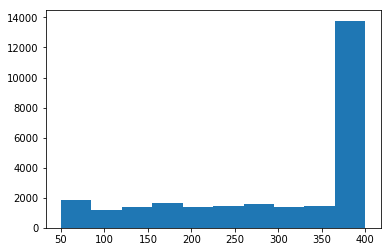

In [49]:
plt.hist(subDF['FPL'])
plt.show()

In [50]:
lowFPLageDFD = {}
highFPLageDFD = {}

for age in range(6, 18):
    df = ageDFD[age]
    print age, df.columns
    lowFPLageDFD[age] = df[df.FPL <= 100]
    highFPLageDFD[age] = df[df.FPL >= 300]

6 Index([u'ACE1', u'ACE3', u'ACE4', u'ACE5', u'ACE6', u'ACE7', u'ACE8', u'ACE9',
       u'ACE10', u'FWC', u'YEAR', u'FPL', u'SC_AGE_YEARS', u'K4Q32X01',
       u'K7Q30', u'K7Q31', u'AGEPOS4', u'ACETOT'],
      dtype='object')
7 Index([u'ACE1', u'ACE3', u'ACE4', u'ACE5', u'ACE6', u'ACE7', u'ACE8', u'ACE9',
       u'ACE10', u'FWC', u'YEAR', u'FPL', u'SC_AGE_YEARS', u'K4Q32X01',
       u'K7Q30', u'K7Q31', u'AGEPOS4', u'ACETOT'],
      dtype='object')
8 Index([u'ACE1', u'ACE3', u'ACE4', u'ACE5', u'ACE6', u'ACE7', u'ACE8', u'ACE9',
       u'ACE10', u'FWC', u'YEAR', u'FPL', u'SC_AGE_YEARS', u'K4Q32X01',
       u'K7Q30', u'K7Q31', u'AGEPOS4', u'ACETOT'],
      dtype='object')
9 Index([u'ACE1', u'ACE3', u'ACE4', u'ACE5', u'ACE6', u'ACE7', u'ACE8', u'ACE9',
       u'ACE10', u'FWC', u'YEAR', u'FPL', u'SC_AGE_YEARS', u'K4Q32X01',
       u'K7Q30', u'K7Q31', u'AGEPOS4', u'ACETOT'],
      dtype='object')
10 Index([u'ACE1', u'ACE3', u'ACE4', u'ACE5', u'ACE6', u'ACE7', u'ACE8', u'ACE9',
       u'ACE10

In [52]:
lowFPLageDFD[6]

,ACE1,ACE3,ACE4,ACE5,ACE6,ACE7,ACE8,ACE9,ACE10,FWC,YEAR,FPL,SC_AGE_YEARS,K4Q32X01,K7Q30,K7Q31,AGEPOS4,ACETOT
678,3.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,714.418874,2016.0,56.0,6.0,1.0,2.0,2.0,1.0,3.0
1130,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,22.616131,2016.0,50.0,6.0,2.0,2.0,2.0,1.0,1.0
1829,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1094.156187,2016.0,72.0,6.0,2.0,1.0,2.0,2.0,2.0
2094,4.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,1.0,1445.356392,2016.0,87.0,6.0,1.0,1.0,2.0,1.0,10.0
3240,3.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,1629.543112,2016.0,88.0,6.0,1.0,2.0,2.0,1.0,3.0
3333,4.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,2.0,2250.260546,2016.0,71.0,6.0,1.0,2.0,2.0,1.0,5.0
3431,2.0,2.0,2.0,2.0,1.0,2.0,2.0,2.0,2.0,32380.775992,2016.0,50.0,6.0,1.0,2.0,2.0,3.0,2.0
3466,4.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,2.0,2889.623463,2016.0,50.0,6.0,1.0,2.0,2.0,2.0,7.0
3874,3.0,1.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1906.315435,2016.0,87.0,6.0,1.0,1.0,1.0,2.0,4.0
4125,3.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,6965.094868,2016.0,50.0,6.0,2.0,2.0,2.0,3.0,2.0


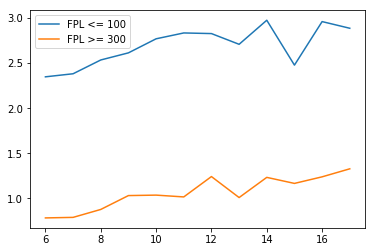

In [60]:
ageL = range(6, 18)
lowL = []
highL = []
for age in ageL:
    samps = mkSamps(lowFPLageDFD[age], 1000)
    lowL.append(samps['ACETOT'].mean())
    samps = mkSamps(highFPLageDFD[age], 1000)
    highL.append(samps['ACETOT'].mean())
plt.plot(ageL, lowL, label='FPL <= 100')
plt.plot(ageL, highL, label='FPL >= 300')
plt.legend()
plt.show()


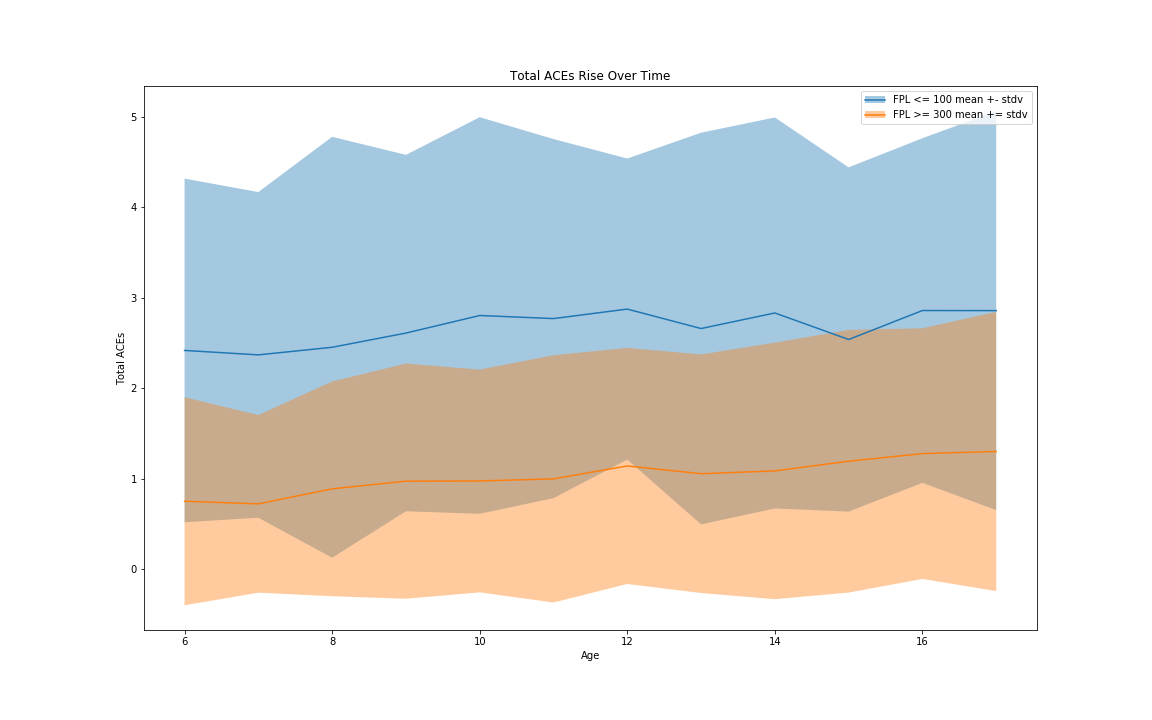

In [79]:
%config InlineBackend.print_figure_kwargs = {'bbox_inches':None}
plt.rcParams["figure.figsize"] = [16, 10]

def calcRange(samps):
    v = samps['ACETOT'].mean()
    sigma = samps['ACETOT'].std()
    return v - sigma, v, v + sigma

ageL = range(6, 18)
lowL = []
lowLBL = []
lowHBL = []
highL = []
highLBL = []
highHBL = []
artistPairL = []
labelL = []
for age in ageL:
    vL, v, vH = calcRange(mkSamps(lowFPLageDFD[age], 1000))
    lowL.append(v)
    lowLBL.append(vL)
    lowHBL.append(vH)
    vL, v, vH = calcRange(mkSamps(highFPLageDFD[age], 1000))
    highL.append(v)
    highLBL.append(vL)
    highHBL.append(vH)
fig, axes = plt.subplots(1,1)
lineArtist, = axes.plot(ageL, lowL, '-')
fillArtist = axes.fill_between(ageL, lowLBL, lowHBL, alpha=0.4)
artistPairL.append((lineArtist, fillArtist))
labelL.append('FPL <= 100 mean +- stdv')
lineArtist, = axes.plot(ageL, highL, '-')
fillArtist = axes.fill_between(ageL, highLBL, highHBL, alpha=0.4)
artistPairL.append((lineArtist, fillArtist))
labelL.append('FPL >= 300 mean += stdv')
axes.legend(artistPairL, labelL, handler_map={tuple: HandlerTuple()})
axes.set_title('Total ACEs Rise Over Time')
axes.set_xlabel('Age')
axes.set_ylabel('Total ACEs')
plt.show()


In [ ]:
    for gpVal, label in zip(gpValL, labelL):
        dayV = allSelMedian[allSelMedian[gpKey]==gpVal][dayKey]
        prevV = allSelMedian[allSelMedian[gpKey]==gpVal][valKey]
        q1V = allSelQ1[allSelQ1[gpKey]==gpVal][valKey]
        q3V = allSelQ3[allSelQ3[gpKey]==gpVal][valKey]
        lineArtist, = axes.plot(dayV, prevV, '-')
        fillArtist = axes.fill_between(dayV, q1V, q3V, alpha=0.4)
        artistPairs.append((lineArtist, fillArtist))
    return artistPairs, [(lbl + ' median and IQR') for lbl in labelL]
